# Practice Session PS05: Recommendation engines (Content-based)

Author: <font color="blue">José M. Pérez Clar</font>

E-mail: <font color="blue">josemaria.perez02@estudiant.upf.edu</font>

Date: <font color="blue">3/11/2023</font>

In [1]:
import pandas as pd   
import numpy as np  
import re
import matplotlib.pyplot as plt  
from math import*
import seaborn as sns
import wordcloud
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

# 1. Load and join the dataset

In [2]:
# Leave this code as-is

FILENAME_MOVIES = "movies-2000s.csv"
FILENAME_RATINGS = "ratings-2000s.csv"
FILENAME_TAGS = "tags-2000s.csv"


In [3]:
# Leave this code as-is

movies = pd.read_csv(FILENAME_MOVIES, 
                    sep=',', 
                    engine='python', 
                    encoding='latin-1',
                    names=['movie_id', 'title', 'genres'])
display(movies.head(5))

ratings_raw = pd.read_csv(FILENAME_RATINGS, 
                    sep=',', 
                    encoding='latin-1',
                    engine='python',
                    names=['user_id', 'movie_id', 'rating'])
display(ratings_raw.head(5))

,movie_id,title,genres
0,2769,"Yards, The (2000)",Crime|Drama
1,3177,Next Friday (2000),Comedy
2,3190,Supernova (2000),Adventure|Sci-Fi|Thriller
3,3225,Down to You (2000),Comedy|Romance
4,3228,Wirey Spindell (2000),Comedy


,user_id,movie_id,rating
0,4,1,3.0
1,4,260,3.5
2,4,296,4.0
3,4,541,4.5
4,4,589,4.0


In [4]:
def yearof(title):
    str = re.search(r'\((\d{4})\)$', title) #I have decided to use regular expressions, although I am aware there might be other ways
    if str:
        return int(str.group(1))
    else:
        return None

movies['year'] = movies['title'].apply(yearof)
display(movies)

,movie_id,title,genres,year
0,2769,"Yards, The (2000)",Crime|Drama,2000.0
1,3177,Next Friday (2000),Comedy,2000.0
2,3190,Supernova (2000),Adventure|Sci-Fi|Thriller,2000.0
3,3225,Down to You (2000),Comedy|Romance,2000.0
4,3228,Wirey Spindell (2000),Comedy,2000.0
...,...,...,...,...
33163,209155,Santosh Subramaniam (2008),Action|Comedy|Romance,2008.0
33164,209157,We (2018),Drama,2018.0
33165,209159,Window of the Soul (2001),Documentary,2001.0
33166,209163,Bad Poems (2018),Comedy|Drama,2018.0


In [5]:
display(ratings_raw)

,user_id,movie_id,rating
0,4,1,3.0
1,4,260,3.5
2,4,296,4.0
3,4,541,4.5
4,4,589,4.0
...,...,...,...
2167697,162536,6942,3.5
2167698,162536,7361,4.5
2167699,162536,8641,4.0
2167700,162536,30749,4.5


We could join ratings_raw and users by using the column in ratings_raw called "user_id", which will necessarily need to be on users too. When it comes to joining ratings_raw and movies, we will join the on the column movie_id, which is present in both dataframes.

In [6]:
ratings = pd.merge(movies, ratings_raw, how='inner', on='movie_id')
display(ratings)

,movie_id,title,genres,year,user_id,rating
0,2769,"Yards, The (2000)",Crime|Drama,2000.0,1115,4.0
1,2769,"Yards, The (2000)",Crime|Drama,2000.0,1209,2.0
2,2769,"Yards, The (2000)",Crime|Drama,2000.0,2004,3.0
3,2769,"Yards, The (2000)",Crime|Drama,2000.0,2502,4.0
4,2769,"Yards, The (2000)",Crime|Drama,2000.0,2827,4.0
...,...,...,...,...,...,...
472966,33166,Crash (2004),Crime|Drama,2004.0,162193,5.0
472967,33166,Crash (2004),Crime|Drama,2004.0,162196,4.5
472968,33166,Crash (2004),Crime|Drama,2004.0,162245,5.0
472969,33166,Crash (2004),Crime|Drama,2004.0,162533,4.0


In [7]:
def find_movies(keyword, movies):
    for index, movie in movies.iterrows():
        if keyword in movie['title']:
            print("movie id:" , movie['movie_id'] , "title:", movie['title'])
            
find_movies("Friday", movies)

movie id: 3177 title: Next Friday (2000)
movie id: 5874 title: Friday After Next (2002)
movie id: 6593 title: Freaky Friday (2003)
movie id: 7880 title: Friday Night (Vendredi Soir) (2002)
movie id: 8937 title: Friday Night Lights (2004)
movie id: 66783 title: Friday the 13th (2009)
movie id: 97175 title: His Name Was Jason: 30 Years of Friday the 13th (2009)
movie id: 121113 title: Shriek If You Know What I Did Last Friday the Thirteenth (2000)
movie id: 133699 title: Black Friday (2004)
movie id: 134649 title: Bad Hair Friday (2012)
movie id: 161157 title: Friday (Pyatnitsa) (2016)
movie id: 171951 title: Monster High: Friday Night Frights (2013)
movie id: 192411 title: Freaky Friday (2018)
movie id: 197903 title: Seven Days: Friday - Sunday (2015)


# 2. Exploratory Data Analysis

## 2.1. "Rating" variable

In [8]:
# Leave this code as-is
ratings['rating'].describe()

count    472971.000000
mean          3.462222
std           1.076063
min           0.500000
25%           3.000000
50%           3.500000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

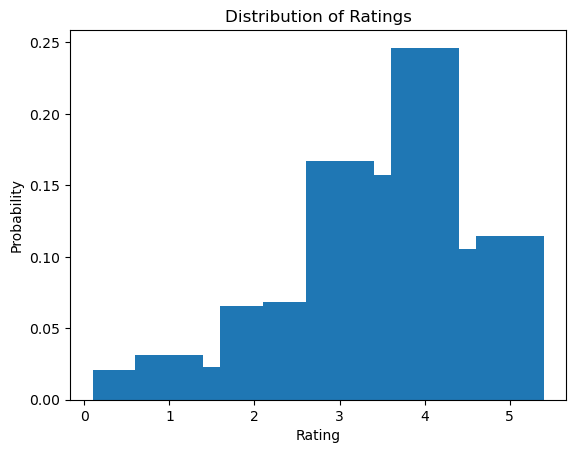

In [9]:
rating_counts = ratings['rating'].value_counts(normalize=True).sort_index() #normalised to obtain the prob of obtaining each rating, not necessary

plt.bar(rating_counts.index, rating_counts.values)
plt.xlabel('Rating')
plt.ylabel('Probability')
plt.title('Distribution of Ratings')
plt.show()


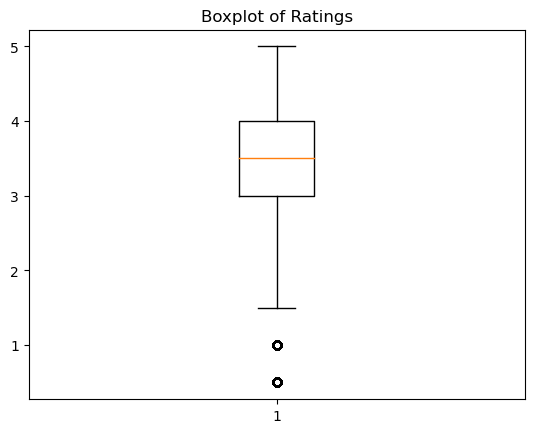

0         4.0
1         2.0
2         3.0
3         4.0
4         4.0
         ... 
472966    5.0
472967    4.5
472968    5.0
472969    4.0
472970    3.5
Name: rating, Length: 472971, dtype: float64

In [10]:
plt.boxplot(ratings['rating'])
plt.title('Boxplot of Ratings')
plt.show()

display(ratings['rating'])

 We can see that the range of values for ratings goes from 0 to 5 in increments of 0.5, that means the possible values are [0.5 , 1 , 1.5 , 2 , 2.5 , 3 , 3.5 , 4 , 4.5 , 5]. Thanks to the plots above, we can see that the two movies for which the ratings are 0.5 and 1 can be identified as outliers, since they have the lowest probability of appearing and can be seen in the boxplot identified as outliers

In [11]:
good_ratings = ratings[ratings['rating'] > 4.0]
bad_ratings = ratings[ratings['rating'] < 2.0]

most_frequent_good_titles = good_ratings['title'].value_counts().nlargest(10)
most_frequent_bad_titles = bad_ratings['title'].value_counts().nlargest(10)

print("10 movies with the most good ratings:\n", most_frequent_good_titles)
print('\n------------------------------------------------------------------\n')
print("10 movies with the most bad ratings:\n", most_frequent_bad_titles)

10 movies with the most good ratings:
 Lord of the Rings: The Fellowship of the Ring, The (2001)    3017
Lord of the Rings: The Return of the King, The (2003)        2792
Lord of the Rings: The Two Towers, The (2002)                2690
Memento (2000)                                               2184
Gladiator (2000)                                             1835
Amelie (Fabuleux destin d'AmÃ©lie Poulain, Le) (2001)        1801
Eternal Sunshine of the Spotless Mind (2004)                 1711
Spirited Away (Sen to Chihiro no kamikakushi) (2001)         1378
Kill Bill: Vol. 1 (2003)                                     1360
Shrek (2001)                                                 1311
Name: title, dtype: int64

------------------------------------------------------------------

10 movies with the most bad ratings:
 Charlie's Angels (2000)                                      338
Battlefield Earth (2000)                                     317
Scary Movie (2000)                    

There are multiple things that we can observe above. On one hand, we see that it is much more frequent to have good ratings than it is to have bad ratings. In fact, it is 10 times more frequent. Other than that, apart from the fact that there are some very well known films in both sections, both for being good and bad, it is very interesting to see that very famous movies such as Lord of the Rings are in both sections. This happens because the movies are so famous that they get many ratings, some of them, negatives. The total number of ratings received for these superpopular movies is so high that they are also the leaders in numbers of negative ratings, something quite understandable, but truly not representative.

For instance, "Lord of the Rings: The Return of the King, The (2003)" is the second film with the most positive ratings and the seventh film with the most negative ratings, however 2792 /(2792 + 223) = 92% of the total of positive and negative ratings are positive, which indicates we can disregard the negatives.

## 2.2. Genres distribution

In [12]:
all_genres = movies['genres'].str.split('|', expand=True).stack().unique()
assert len(all_genres) == 20

In [13]:
genres_count = movies['genres'].str.split('|', expand=True).stack().value_counts()
genres_count.columns = ['Genre', 'Frequency']

display(genres_count)

Drama                 13666
Comedy                 8898
Thriller               5437
Documentary            4473
Action                 3901
Romance                3846
Horror                 3431
Crime                  2425
(no genres listed)     2200
Sci-Fi                 1907
Adventure              1906
Children               1639
Animation              1553
Mystery                1516
Fantasy                1456
War                     679
Musical                 308
Western                 194
IMAX                    173
Film-Noir                21
dtype: int64

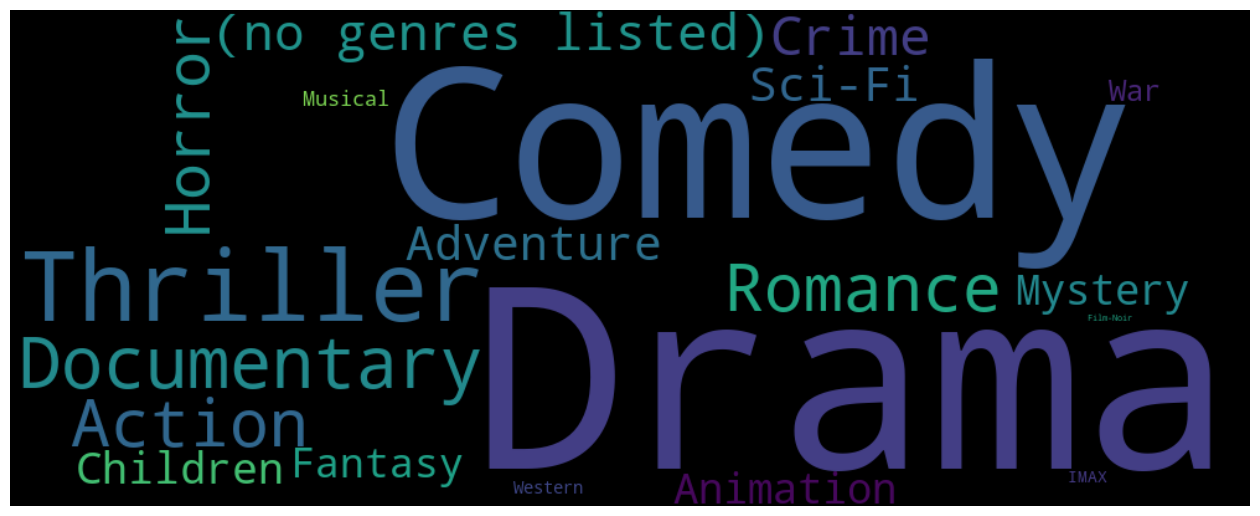

In [14]:
# Change the colors/style if you want

# Generate the word cloud
genre_wordcloud = WordCloud(width=1000, height=400, background_color='black')
genre_wordcloud.generate_from_frequencies(dict(genres_count))

# Plot the word cloud
f, ax = plt.subplots(figsize=(16, 8))
plt.imshow(genre_wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

PRE 2010 PLOT:



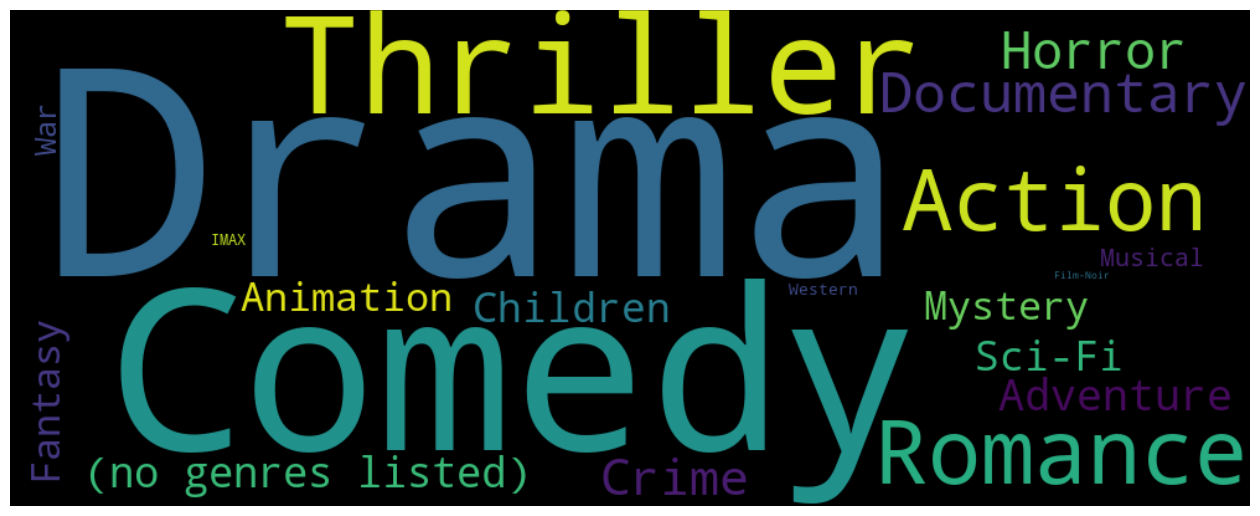

POST 2010 PLOT:



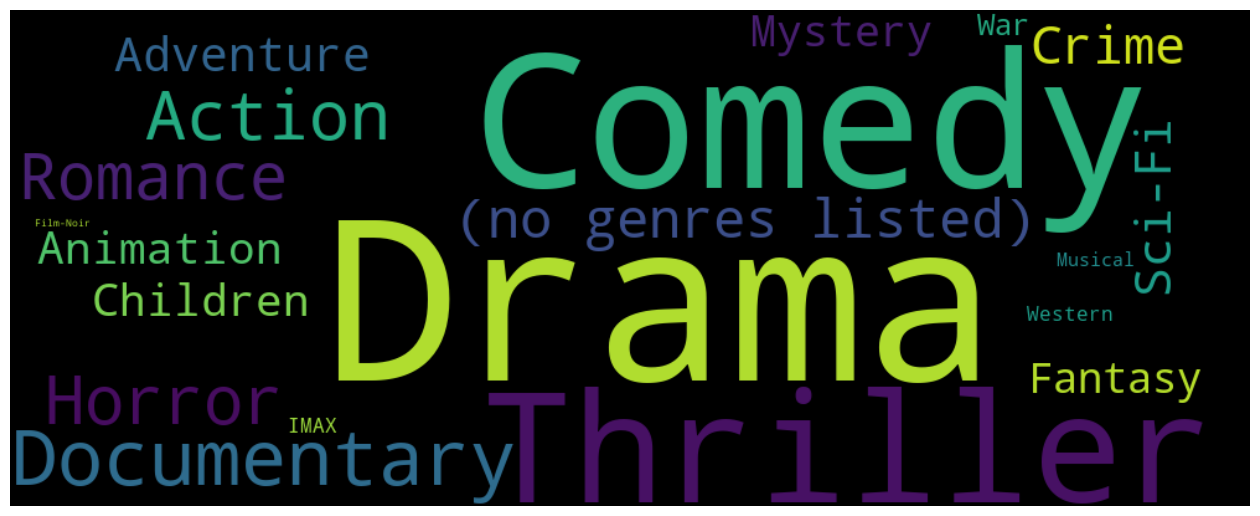

In [15]:
pre2010 = movies[movies["year"] < 2010.0]
post2010 = movies[movies["year"] >= 2010.0]

genres_count_pre2010 = pre2010['genres'].str.split('|', expand=True).stack().value_counts()
genres_count_pre2010.columns = ['Genre', 'Frequency']

genres_count_post2010 = post2010['genres'].str.split('|', expand=True).stack().value_counts()
genres_count_post2010.columns = ['Genre', 'Frequency']

print("PRE 2010 PLOT:\n")

genre_wordcloud = WordCloud(width=1000, height=400, background_color='black')
genre_wordcloud.generate_from_frequencies(dict(genres_count_pre2010))

f, ax = plt.subplots(figsize=(16, 8))
plt.imshow(genre_wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

print("POST 2010 PLOT:\n")

genre_wordcloud = WordCloud(width=1000, height=400, background_color='black')
genre_wordcloud.generate_from_frequencies(dict(genres_count_post2010))

# Plot the word cloud
f, ax = plt.subplots(figsize=(16, 8))
plt.imshow(genre_wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

The plot is not particularly informative in the sense that the three main genres have stayed the same (Thriller, Drama and Comedy). Other than that, we can see how Romance has become slightly less relevant together with Action, which was one of the main genres before the 2010 but that has become much less popular.

Other than that adventure and crime have also become less popular and it seems like the diversity post 2010 has been reduced, with 3 very clearly dominant genres, and a fair-share of somewhat relevant genres that are clearly not at the same level of popularity. Musical has become significantly less popular aswell.

# 3. Content-based recommendation

## 3.1. Compute TF-IDF vectors

In [16]:
movies['genres_arr'] = movies['genres'].str.split('|').fillna('').astype('str')

In [17]:
# Leave this code as-is

print("Transformed: %s → %s" % (movies['genres'][3], movies['genres_arr'][3]))

Transformed: Comedy|Romance → ['Comedy', 'Romance']


In [18]:
# LEAVE AS-IS

# The reset-index is important to match row/column numbers in the tdifd-matrix
movies_filtered = movies[movies.year > 2015]
movies_filtered = movies_filtered.reset_index()
display(movies_filtered)

,index,movie_id,title,genres,year,genres_arr
0,10897,122888,Ben-hur (2016),(no genres listed),2016.0,['(no genres listed)']
1,10898,122890,Warcraft (2016),Action|Adventure|Fantasy,2016.0,"['Action', 'Adventure', 'Fantasy']"
2,10900,122896,Pirates of the Caribbean: Dead Men Tell No Tal...,(no genres listed),2017.0,['(no genres listed)']
3,10901,122898,Justice League (2017),Action|Adventure|Sci-Fi,2017.0,"['Action', 'Adventure', 'Sci-Fi']"
4,10904,122904,Deadpool (2016),Action|Adventure|Comedy|Sci-Fi,2016.0,"['Action', 'Adventure', 'Comedy', 'Sci-Fi']"
...,...,...,...,...,...,...
7885,33159,209143,The Painting (2019),Animation|Documentary,2019.0,"['Animation', 'Documentary']"
7886,33160,209145,LibertÃ© (2019),Drama,2019.0,['Drama']
7887,33161,209151,Mao Zedong 1949 (2019),(no genres listed),2019.0,['(no genres listed)']
7888,33164,209157,We (2018),Drama,2018.0,['Drama']


In [19]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2))
tfidf_matrix = tfidf_vectorizer.fit_transform(movies_filtered['genres_arr'])
print(tfidf_matrix.shape)

(7890, 130)


## 3.2. Calculate most similar movies

In [20]:
# Leave this code as-is
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
print(cosine_sim)

[[1.         0.         1.         ... 1.         0.         0.        ]
 [0.         1.         0.         ... 0.         0.         0.        ]
 [1.         0.         1.         ... 1.         0.         0.        ]
 ...
 [1.         0.         1.         ... 1.         0.         0.        ]
 [0.         0.         0.         ... 0.         1.         0.41022264]
 [0.         0.         0.         ... 0.         0.41022264 1.        ]]


In [21]:
# Leave this code as-is

# Create an index to convert from numbers to movie_id
movie_id_to_index = pd.Series(movies_filtered.index, index=movies_filtered['movie_id'])

# Print the similarity vector
def print_similarity_vector(movie_id, similarities):
    
    # Determine the index of the movie_id
    index_source = movie_id_to_index[movie_id]
    
    # Get the row in the similarities matrix
    sim_scores = list(similarities[index_source])

    # Iterate through that row
    for index_target in range(len(sim_scores)):
        print("%.3f %d %s" %
              (sim_scores[index_target], movies_filtered.iloc[index_target].movie_id, movies_filtered.iloc[index_target].title))
        
print_similarity_vector(122904, cosine_sim)

0.000 122888 Ben-hur (2016)
0.362 122890 Warcraft (2016)
0.000 122896 Pirates of the Caribbean: Dead Men Tell No Tales (2017)
0.600 122898 Justice League (2017)
1.000 122904 Deadpool (2016)
0.600 122906 Black Panther (2017)
0.600 122908 Inhumans (2018)
0.600 122910 Captain Marvel (2018)
0.600 122912 Avengers: Infinity War - Part I (2018)
0.600 122914 Avengers: Infinity War - Part II (2019)
0.600 122916 Thor: Ragnarok (2017)
0.600 122918 Guardians of the Galaxy 2 (2017)
0.359 122920 Captain America: Civil War (2016)
0.600 122922 Doctor Strange (2016)
0.504 122924 X-Men: Apocalypse (2016)
0.362 122926 Untitled Spider-Man Reboot (2017)
0.440 135141 Allegiant: Part 1 (2016)
0.000 135143 Fantastic Beasts and Where to Find Them (2016)
0.000 135426 Fantastic Beasts and Where to Find Them 2 (2018)
0.056 135436 The Secret Life of Pets (2016)
0.326 135530 Criminal (2016)
0.309 135536 Suicide Squad (2016)
0.600 135567 Independence Day: Resurgence (2016)
0.600 135569 Star Trek Beyond (2016)
0.000 

0.119 159970 Never Back Down: No Surrender (2016)
0.305 159972 Approaching the Unknown (2016)
0.000 159976 PelÃ©: Birth of a Legend (2016)
0.419 160012 Andron (2016)
0.000 160020 The Witness (2016)
0.000 160056 Hard Sell (2016)
0.354 160080 Ghostbusters (2016)
0.000 160084 Henry Gamble's Birthday Party (2016)
0.352 160112 Cell (2016)
0.000 160124 A Dragon Arrives! (2016)
0.000 160141 Girl in Woods (2016)
0.000 160149 Complete Unknown (2016)
0.000 160161 Bang Gang (A Modern Love Story) (2016)
0.238 160169 The Asian Connection (2016)
0.000 160183 The Art of Organized Noize (2016)
0.056 160193 Adam Green's Aladdin (2016)
0.087 160201 La pazza gioia (2016)
0.066 160236 Be Somebody (2016)
0.179 160271 Central Intelligence (2016)
0.000 160289 O.J.: Made in America (2016)
0.000 160291 Mother, May I Sleep with Danger? (2016)
0.000 160301 Udta Punjab (2016)
0.000 160317 Roots (2016)
0.000 160319 We are Twisted Fucking Sister! (2016)
0.000 160360 How to Let Go of the World and Love All the Thing

0.087 165895 Spaceman (2016)
0.178 165897 Army of One (2016)
0.066 165901 Happy Bhag Jayegi (2016)
0.000 165925 The Congressman (2016)
0.118 165931 Ivan Tsarevich & the Grey Wolf 3 (2016)
0.000 165933 The Ivory Game (2016)
0.000 165937 Collateral Beauty (2016)
0.087 165939 First Girl I Loved (2016)
0.179 165947 The True Memoirs of an International Assassin (2016)
0.000 165949 You Will Know What to Do With Me (2016)
0.087 165951 Saint Amour (2016)
0.000 165969 HyperNormalisation (2016)
0.042 166005 La folle histoire de Max et LÃ©on (2016)
0.000 166009 The Chronicles of Melanie (2016)
0.000 166011 Shangri-La Suite (2016)
0.572 166013 Scrat: Spaced Out (2016)
0.087 166015 The African Doctor (2016)
0.000 166020 Dog Eat Dog (2016)
0.000 166022 Justin Timberlake + The Tennessee Kids (2016)
0.000 166030 Invisible (2016)
0.119 166054 Maliglutit (Searchers) (2016)
0.000 166126 Wet Woman in the Wind (2016)
0.000 166140 The Untamed (2016)
0.000 166143 Riphagen (2016)
0.000 166149 A United Kingdom

0.000 169210 A Good Wife (2017)
0.000 169216 Spoor (2017)
0.000 169218 God's Own Country (2017)
0.000 169220 A Fantastic Woman (2017)
0.000 169222 Colo (2017)
0.000 169224 Deadly Daughters (2016)
0.000 169242 Ana, mon amour (2017)
0.000 169244 Hostages (2017)
0.238 169248 Kill Ratio (2016)
0.040 169250 Trash Fire (2016)
0.000 169256 Lovesong (2017)
0.178 169264 Jen Kirkman: Just Keep Livinâ? (2017)
0.178 169266 Colin Quinn: The New York Story (2016)
0.178 169268 Cedric the Entertainer: Live from the Ville (2016)
0.178 169274 The Fabulous Pastars (2016)
0.178 169280 The Fourth Annual 'On Cinema' Oscar Special (2016)
0.549 169288 Major Grom (2017)
0.000 169294 Becoming Warren Buffett (2017)
0.000 169298 Drifter (2016)
0.178 169302 Everybody Loves Somebody (2017)
0.000 169304 The Reconquest (2016)
0.000 169306 Max Rose (2016)
0.178 169308 Matt Besser: Besser Breaks The Record (2016)
0.178 169312 Tony Hinchcliffe: One Shot (2016)
0.178 169314 Whitney Cummings: I'm Your Girlfriend (2016)


0.301 171123 Burn Your Maps (2017)
0.000 171127 The Irresistible Blueberry Farm (2016)
0.000 171129 Tommy's Honour (2016)
0.000 171131 My Way: The Rise and Fall of Silvio Berlusconi (2016)
0.000 171141 Handsome Devil (2016)
0.000 171157 Lowriders (2017)
0.000 171165 Hell (2017)
0.299 171193 The Dark Tapes (2017)
0.000 171201 Mythica: The Godslayer (2016)
0.419 171207 Beyond Skyline (2017)
0.178 171209 Punching Henry (2017)
0.000 171225 Sam Was Here (2016)
0.178 171227 How to Be a Latin Lover (2017)
0.087 171233 The Trip to Spain (2017)
0.000 171251 Nobody Speak: Hulk Hogan, Gawker and Trials of a Free Press (2017)
0.178 171253 Brigsby Bear (2017)
0.178 171261 Lucas Brothers: On Drugs (2017)
0.066 171263 Tramps (2016)
0.000 171265 I Am Heath Ledger (2017)
0.000 171309 Killing Reagan (2016)
0.108 171311 The Loner (2016)
0.000 171313 Origin (2016)
0.000 171315 Sand Castle (2017)
0.178 171323 Slam (2016)
0.000 171327 Mifune: The Last Samurai (2016)
0.600 171337 Moontrap Target Earth (2017)

0.178 175987 With Open Arms (2017)
0.000 175991 Scribe (2017)
0.178 175995 The Visitors: Bastille Day (2016)
0.000 176051 LEGO DC Super Hero Girls: Brain Drain (2017)
0.058 176057 Take Me (2017)
0.000 176061 A Death in the Gunj (2016)
0.037 176063 Phillauri (2017)
0.066 176073 The Incredible Jessica James (2017)
0.000 176075 The Defiant Ones (2017)
0.000 176079 Provoked (2016)
0.000 176085 It Stains the Sands Red (2016)
0.087 176099 The Resurrection of Gavin Stone (2017)
0.720 176101 Kingsman: The Golden Circle (2017)
0.115 176103 The LEGO Ninjago Movie (2017)
0.301 176105 Flatliners (2017)
0.000 176111 Wheeler (2017)
0.000 176113 Can't Buy My Love (2017)
0.000 176115 Hopeless Romantic (2016)
0.092 176165 Cop and a Half: New Recruit (2017)
0.000 176173 Killing Ground (2017)
0.000 176189 The Sublet (2017)
0.000 176211 In a Heartbeat (2017)
0.000 176247 Person to Person (2017)
0.000 176249 Mom (2017)
0.281 176261 Demon Hunter (2016)
0.000 176279 Queerama (2017)
0.000 176283 Abortion: Sto

0.000 177787 Chappaquiddick (2017)
0.178 177791 Going to Brazil (2017)
0.000 177793 Little Door Gods (2016)
0.101 177795 Z-Office (2017)
0.087 177807 Bodied (2017)
0.000 177809 Jackson (2016)
0.000 177819 Kiss and Cry (2017)
0.087 177821 Bloody Milk (2017)
0.000 177825 Live Cargo (2016)
0.131 177835 The Killer in the House (2016)
0.000 177851 We Are Not Alone (2016)
0.000 177853 The Journey Is the Destination (2016)
0.000 177857 David Gilmour - Live at Pompeii (2017)
0.066 177865 Un Profil pour deux (2017)
0.000 177867 Borg vs McEnroe (2017)
0.000 177871 Victoria & Abdul (2017)
0.000 177877 Slasher.com (2017)
0.178 177879 Ryan Hamilton: Happy Face (2017)
0.178 177883 Jerry Before Seinfeld (2017)
0.000 177913 Back to Burgundy (2017)
0.087 177915 Elementary (2017)
0.178 177917 Papa ou maman 2 (2016)
0.000 177939 The Night Is Short, Walk on Girl (2017)
0.000 177949 Kill or Be Killed (2016)
0.000 177951 Happy! (2017)
0.238 177963 Rumble (2016)
0.000 177967 Pitchfork (2016)
0.000 177991 Ano

0.000 180069 Love and Goodbye and Hawaii (2017)
0.087 180073 The Fury (2016)
0.000 180075 The Connected Universe (2016)
0.000 180081 Oro (2017)
0.114 180091 PokÃ©mon the Movie: I Choose You! (2017)
0.492 180093 Singularity (2017)
0.000 180095 Wonder (2017)
0.000 180097 Christmas Crime Story (2017)
0.000 180099 The Big Bad Fox and Other Tales (2017)
0.310 180109 CzÅowiek z magicznym pudeÅkiem (2017)
0.000 180133 Big Sonia (2017)
0.087 180137 See You Up There (2017)
0.000 180155 The Paris Opera (2017)
0.000 180157 Et les mistrals gagnants (2017)
0.000 180221 Walk with Me (2017)
0.000 180223 Sexology (2016)
0.178 180227 God: Serengeti (2017)
0.087 180231 Daddy's Home 2 (2017)
0.000 180245 Ittefaq: It happened one night (2017)
0.000 180249 No Date, No Signature (2017)
0.419 180251 Geo-Disaster (2017)
0.087 180253 Gabriel and the Mountain (2017)
0.000 180261 The Bookshop (2017)
0.000 180265 Jim & Andy: The Great Beyond (2017)
0.000 180267 Blame (2017)
0.087 180269 Hotel Salvation (2016)
0

0.061 183445 Aile ArasÄ±nda (2017)
0.000 183455 Scooby-Doo! & Batman: The Brave and the Bold (2018)
0.101 183457 Day of the Dead: Bloodline (2018)
0.000 183459 The Midnight Man (2016)
0.000 183461 Godless (2017)
0.000 183467 Treasure Hounds (2017)
0.000 183469 Memo (2016)
0.087 183475 Abe & Phil's Last Poker Game (2018)
0.000 183487 Valentine's Again (2017)
0.178 183489 Life Ahead (2017)
0.000 183491 My Name Is Lenny (2017)
0.178 183497 The Polka King (2018)
0.000 183499 Promise at Dawn (2017)
0.000 183503 I Am Here (2016)
0.119 183507 Voldemort: Origins of the Heir (2018)
0.000 183515 A Man of Integrity (2018)
0.000 183519 Kenny (2017)
0.000 183521 Don't Sleep (2017)
0.000 183525 Nothing Really Happened (2017)
0.000 183529 Bad Day for the Cut (2017)
0.057 183533 Ice Mother (2017)
0.178 183547 T.J. Miller: Meticulously Ridiculous (2017)
0.178 183565 Come un gatto in tangenziale (2017)
0.178 183567 F*&% the Prom (2017)
0.179 183569 Gangsterdam (2017)
0.140 183571 Mystic Game (2017)
0.00

0.140 185025 Beyond the Edge (2018)
0.000 185027 A Winter Rose (2016)
0.000 185029 A Quiet Place (2018)
0.132 185031 Alpha (2018)
0.000 185033 I Kill Giants (2018)
0.000 185037 Never Here (2017)
0.000 185051 Haunters: The Art of the Scare (2017)
0.056 185077 Hanson and the Beast (2017)
0.000 185087 A Trip to the Moon (2017)
0.000 185105 Con Man (2018)
0.178 185107 Schubert in Love (2016)
0.000 185109 Disobedience (2018)
0.000 185111 Gangsta (2018)
0.000 185129 NiÃ±as AraÃ±a (2017)
0.000 185161 The Elf (2017)
0.000 185165 I babysitter (2016)
0.419 185167 Battle of the Drones (2017)
0.000 185169 The Strangers: Prey at Night (2018)
0.080 185171 The Hurricane Heist (2018)
0.000 185207 Germans & Jews (2016)
0.000 185229 The Bad Kids (2016)
0.000 185245 MartÃ­rio (2017)
0.087 185261 Number One (2017)
0.000 185263 Deaf child (2017)
0.088 185267 Paradox (2017)
0.000 185271 The Intruder (2017)
0.066 185285 Ice (2018)
0.000 185287 Nature Boy (2017)
0.000 185295 The Outsider (2018)
0.000 185303 T

0.000 187473 Love Education (2017)
0.000 187477 Night Bus (2017)
0.119 187479 Steel Rain (2017)
0.000 187481 The Beach House (2018)
0.028 187483 Spreading Darkness (2017)
0.178 187495 Candy Jar (2018)
0.000 187501 Leave No Trace (2018)
0.178 187505 Tully (2018)
0.000 187507 The Problem with Apu (2017)
0.000 187509 Vampire Clay (2018)
0.000 187511 The Delinquent Season (2017)
0.000 187515 Corporate (2017)
0.178 187517 Michelle Wolf: Nice Lady (2017)
0.000 187523 The Captain (2018)
0.000 187525 2016 Oscar Nominated Short Films: Live Action (2016)
0.087 187529 Egg (2018)
0.178 187531 John Mulaney: Kid Gorgeous at Radio City (2018)
0.178 187537 Sensitivity Training (2016)
0.319 187541 Incredibles 2 (2018)
0.000 187543 The Nameless Alley (2016)
0.000 187547 Take Every Wave: The Life of Laird Hamilton (2017)
0.000 187549 Wonderful Losers: A Different World (2017)
0.000 187551 Bille (2018)
0.000 187557 Parisienne (2016)
0.000 187559 On Her Shoulders (2018)
0.000 187561 Of Fathers and Sons (20

0.108 189039 Hunting Emma (2017)
0.075 189041 Sicario: Day of the Soldado (2018)
0.087 189043 Boundaries (2018)
0.178 189049 Adventures In Public School (2017)
0.000 189051 Run the Tide (2016)
0.000 189055 Pound for Pound (2017)
0.000 189061 In Darkness (2018)
0.178 189063 Brad Paisley's Comedy Rodeo (2017)
0.178 189065 Steve Martin and Martin Short: An Evening You Will Forget for the Rest of Your Life (2018)
0.000 189071 The Tale (2018)
0.000 189073 Happily Ever After (2016)
0.000 189077 Alipato: The Very Brief Life of an Ember (2016)
0.367 189085 See You Yesterday (2017)
0.000 189097 The Misandrists (2017)
0.178 189099 Show Dogs (2018)
0.000 189101 The Desert Bride (2017)
0.000 189103 The Guardians (2017)
0.178 189105 Class Rank (2018)
0.000 189107 Anything (2017)
0.000 189109 Pandas (2018)
0.000 189111 Spiral (2018)
0.000 189113 Love & Bananas: An Elephant Story (2018)
0.425 189115 The Escape of Prisoner 614 (2018)
0.000 189117 They Remain (2018)
0.087 189119 Souvenir (2016)
0.000 1

0.178 191113 Jim Jefferies: This Is Me Now (2018)
0.000 191119 Juggernaut (2017)
0.000 191123 Dark Harvest (2016)
0.000 191129 Alleluia! The Devil's Carnival (2016)
0.066 191131 Girls Like Magic (2017)
0.000 191139 Mad to Be Normal (2017)
0.087 191141 The Honey Killer (2018)
0.000 191143 The Trial (2018)
0.000 191147 Prescription for Danger (2018)
0.000 191153 Johnny Frank Garrett's Last Word (2016)
0.000 191171 Chasing Asylum (2016)
0.178 191177 C'est tout pour moi! (2017)
0.000 191179 Maryline (2017)
0.000 191197 A Beautiful Demon: Kazuo Koike on Lady Snowblood (2016)
0.000 191205 Killer Construction: Norio Osada on Lady Snowblood (2016)
0.000 191207 The Heart of Man (2017)
0.492 191213 Encounter (2018)
0.280 191217 Magellan (2017)
0.319 191235 GODZILLA: City on the Edge of Battle (2018)
0.000 191237 All I Need (2016)
0.311 191241 Kung Fu Traveler 2 (2018)
0.238 191243 The Archer (2017)
0.000 191247 Alp (2016)
0.000 191253 Billionaire Boys Club (2018)
0.064 191255 Hell's Kitty (2018)

0.000 192821 Seed: The Untold Story (2016)
0.000 192823 Crime + Punishment (2018)
0.000 192825 Who We Are Now (2018)
0.178 192827 Jawani Phir Nahi Ani 2 (2018)
0.000 192835 Lake Placid: Legacy (2018)
0.178 192841 Das schÃ¶nste MÃ¤dchen der Welt (2018)
0.041 192847 I've Always Liked You (2016)
0.178 192849 Bert Kreischer: Secret Time (2018)
0.087 192855 Happier times, Grump (2018)
0.083 192861 Corbin Nash (2018)
0.282 192865 Meteors (2017)
0.000 192875 Yardie (2018)
0.000 192883 Beacon Point (2016)
0.000 192889 Liberated: The New Sexual Revolution (2017)
0.178 192901 Les Vieux Fourneaux (2018)
0.000 192903 Tonight, At the Movies (2018)
0.492 192911 A.X.L. (2018)
0.000 192919 ConsommÃ© (2016)
0.000 192927 The Last Suit (2017)
0.000 192929 A Touch of Spring (2017)
0.000 192931 Jan Palach (2018)
0.000 192933 Rosie (2018)
0.000 192941 Yonlu (2017)
0.000 192943 Beuys (2017)
0.000 192945 Sollers Point (2017)
0.717 192957 Future Boyfriend (2016)
0.363 192963 FTL (2017)
0.119 192981 Penguin Hig

0.000 194336 Blue Night (2018)
0.000 194340 The Eternal Feminine (2018)
0.000 194342 Time Share (2018)
0.000 194344 JoÃ£o, O Maestro (2017)
0.000 194346 The Vanished (2018)
0.048 194348 Can You Ever Forgive Me? (2018)
0.000 194350 Monrovia, Indiana (2018)
0.000 194352 Feminists: What Were They Thinking? (2018)
0.057 194356 Oru Naal Koothu (2016)
0.178 194358 Threesomething (2018)
0.000 194360 Varathan (2018)
0.087 194362 Mangalyam Thanthunanena (2018)
0.238 194364 Ranam : Detroit Crossing (2018)
0.052 194366 Kolamavu Kokila (2018)
0.066 194368 Oru Pazhaya Bomb Kadha (2018)
0.000 194372 The Seasons in Quincy: Four Portraits of John Berger (2017)
0.257 194396 Overlord (2018)
0.151 194398 Dead in a Week (Or Your Money Back) (2018)
0.000 194400 Widows (2018)
0.000 194402 Quincy (2018)
0.628 194440 The Last Sharknado: It's About Time (2018)
0.087 194448 Green Book (2018)
0.000 194450 Her Smell (2018)
0.000 194452 The Tokyo Night Sky Is Always the Densest Shade of Blue (2017)
0.000 194468 Sl

0.000 196949 Retablo (2018)
0.087 196951 Tucked (2018)
0.057 196953 Anchor and Hope (2017)
0.000 196957 Stronger Than The World: The Story of JosÃ© Aldo (2016)
0.000 196959 I Am JFK Jr. (2016)
0.238 196969 Master Z: Ip Man Legacy (2018)
0.000 196971 Vele hemels boven de zevende (2017)
0.056 196973 The Shivering Truth (2018)
0.075 196975 Sky Hunter (2017)
0.312 196979 Andover (2018)
0.000 196981 American Umpire (2016)
0.124 196983 Hello Gangster (2016)
0.000 196985 Classical Period (2018)
0.000 196987 Far from the Tree (2017)
0.253 196997 Black Mirror: Bandersnatch (2018)
0.178 197007 Night Out (2018)
0.000 197009 Struggle: The Life and Lost Art of Szukalski (2018)
0.000 197011 Grass (2018)
0.000 197013 One Nation, One King (2018)
0.000 197015 Pool Party Massacre (2017)
0.000 197017 Looping (2016)
0.000 197019 Derren Brown: Pushed to the Edge (2016)
0.000 197027 Nowhere Mind (2018)
0.087 197029 Freak Show (2018)
0.000 197033 Blood Is Blood (2016)
0.057 197037 Fidaa (2017)
0.899 197039 A

0.178 199900 Wide Load (2019)
0.064 199902 30 Miles from Nowhere (2018)
0.076 199904 Goyo: The Boy General (2018)
0.000 199908 A Tuba To Cuba (2018)
0.000 199910 The Professor and the Madman (2019)
0.000 199912 Into the Dark: Flesh & Blood (2018)
0.000 199914 Trust Machine: The Story of Blockchain (2018)
0.066 199920 Loving Cuba (2019)
0.178 199922 Bon Bini Holland 2 (2018)
0.000 199924 Vicious (2019)
0.000 199928 My Extraordinary Summer with Tess (2019)
0.000 199930 Sheep Hero (2019)
0.067 199932 Vechtmeisje (2018)
0.305 199934 Incontrol (2017)
0.000 199940 The Changeover (2017)
0.068 199944 Big Kill (2018)
0.000 199948 Never Grow Old (2019)
0.178 199950 La monnaie de leur piÃ¨ce (2018)
0.087 199958 Yes, God, Yes (2017)
0.087 199960 Khook (2018)
0.000 199964 By The Grace of God (2019)
0.000 199966 System Crasher (2019)
0.000 199968 Piranhas (2019)
0.000 199970 God Exists, Her Name is Petrunya (2019)
0.000 199974 Hotel Mumbai (2019)
0.000 199982 The Wedding Guest (2019)
0.000 199984 eH

0.178 203449 The Lonely Island Presents: The Unauthorized Bash Brothers Experience (2019)
0.000 203453 RemÃ©lem legkÃ¶zelebb sikerÃ¼l meghalnod :) (2018)
0.000 203483 In Safe Hands (2018)
0.087 203485 French Tour (2016)
0.087 203491 Best Intentions (2018)
0.000 203495 Sibyl (2019)
0.178 203499 J'ai perdu Albert (2018)
0.000 203501 Catholics vs. Convicts (2016)
0.058 203503 Deerskin (2019)
0.000 203505 Cassandro, the Exotico! (2018)
0.000 203509 FP2: Beats of Rage (2018)
0.000 203511 The Uncovering (2018)
0.000 203513 Annabelle Comes Home (2019)
0.321 203517 The Angry Birds Movie 2 (2019)
0.238 203519 Fast & Furious Presents: Hobbs & Shaw (2019)
0.000 203521 A Translator (2019)
0.000 203523 Nightmare Cinema (2019)
0.087 203525 Kate Canât Swim (2017)
0.000 203533 All Good (2018)
0.000 203537 Vidas Partidas (2016)
0.178 203539 Heel Kick! (2017)
0.087 203557 Fisherman's Friends (2019)
0.000 203559 The Warden (2019)
0.087 203561 The Plagiarists (2019)
0.000 203563 Ambivalence (2019)
0.000

0.000 204802 The Family (2019)
0.178 204804 Bob Saget: Zero to Sixty (2017)
0.178 204808 Ramy Youssef: Feelings (2019)
0.154 204812 Digimon Adventure Tri. - Chapter 2: Determination (2016)
0.154 204814 Digimon Adventure Tri. - Chapter 3: Confession (2016)
0.385 204816 Digimon Adventure Tri. - Chapter 4: Loss (2017)
0.154 204818 Digimon Adventure Tri. - Chapter 5: Coexistence (2017)
0.000 204820 Digimon Adventure Tri. - Chapter 6: Future (2018)
0.000 204826 The Kitchen (2019)
0.056 204832 Rocko's Modern Life: Static Cling (2019)
0.075 204834 Danger Close: The Battle of Long Tan (2019)
0.087 204836 The Art of Racing in the Rain (2019)
0.000 204840 The Operative (2019)
0.000 204844 Winter Ridge (2018)
0.000 204868 Light of My Life (2019)
0.087 204878 Dolemite Is My Name (2019)
0.000 204924 The Ancient Woods (2018)
0.000 204926 Bomb, Yek Asheghaneh (2018)
0.000 204966 Luce (2019)
0.000 204980 Roll Red Roll (2019)
0.000 204990 Building Star Trek (2016)
0.179 204994 Iceman: The Time Traveler

0.000 207293 Isabelle (2019)
0.000 207295 Ouija Seance: The Final Game (2018)
0.090 207297 First Love (2019)
0.000 207309 Fractured (2019)
0.066 207311 Last Christmas (2019)
0.034 207313 Knives Out (2019)
0.280 207315 Illusions (2017)
0.000 207319 SesiÃ³n salvaje (2019)
0.000 207323 The 8-Year Engagement (2017)
0.000 207331 Pacarrete (2019)
0.000 207341 The Forest (2018)
0.000 207343 The Forest of Love (2019)
0.000 207345 Into the Amazon (2018)
0.143 207347 Spread Your Wings (2019)
0.000 207349 Judy & Punch (2019)
0.119 207357 The Rising Hawk (2019)
0.080 207359 Lucky Day (2019)
0.064 207367 Little Monsters (2019)
0.000 207369 Selfie (2019)
0.000 207401 Businessmen (2018)
0.000 207403 Someone, Somewhere (2019)
0.000 207405 Doctor Sleep (2019)
0.000 207409 Deserted (2016)
0.000 207415 The Boat (2019)
0.000 207417 Mary (2019)
0.000 207429 Aurora (2018)
0.000 207439 Virus (2019)
0.000 207451 Birthday Card (2016)
0.000 207453 Tuna Girl (2019)
0.000 207457 LEGO DC: Batman - Family Matters (

In [22]:
def genre_content_based_recommendations(movie_id, movies, similarities, num_movies=10):

    index_source = movie_id_to_index[movie_id]

    # Enumerate similarities and sort by similarity in descending order
    enumerated_similarities = list(enumerate(similarities[index_source]))
    sorted_similarities = sorted(enumerated_similarities, key=lambda x: x[1], reverse=True)
    top_similarities = sorted_similarities[:num_movies]

    
    recommendations = []
    for (index_target, similarity) in top_similarities:

        # Replace this comment with code to obtain movie_id, title, genres
        target_movie = movies.iloc[index_target] #used iloc, could use a for loop or other ways to locate the target movie
        movie_id = target_movie['movie_id']
        title = target_movie['title']
        genres = target_movie['genres']

        recommendations.append({
                'movie_id': movie_id,
                'title': title,
                'genres': genres,
                'similarity': similarity
            }
        )

    return pd.DataFrame.from_records(recommendations, columns=['similarity', 'movie_id', 'title', 'genres'])

In [23]:
display(genre_content_based_recommendations(122896, movies, cosine_sim, 10))
display(genre_content_based_recommendations(201646, movies, cosine_sim, 10))

,similarity,movie_id,title,genres
0,1.0,2769,"Yards, The (2000)",Crime|Drama
1,1.0,3190,Supernova (2000),Adventure|Sci-Fi|Thriller
2,1.0,3303,Black Tar Heroin: The Dark End of the Street (...,Documentary
3,1.0,3354,Mission to Mars (2000),Sci-Fi
4,1.0,3409,Final Destination (2000),Drama|Thriller
5,1.0,3511,Ready to Rumble (2000),Comedy
6,1.0,3555,U-571 (2000),Action|Thriller|War
7,1.0,3582,"Jails, Hospitals & Hip-Hop (2000)",Comedy|Documentary|Drama
8,1.0,3594,Center Stage (2000),Drama|Musical
9,1.0,3752,"Me, Myself & Irene (2000)",Adventure|Comedy


,similarity,movie_id,title,genres
0,1.0,3909,Woman on Top (2000),Comedy|Romance
1,1.0,5094,Rollerball (2002),Action|Sci-Fi
2,1.0,5153,Trouble Every Day (2001),Drama|Horror|Thriller
3,1.0,6758,Emerald Cowboy (2002),Documentary|Drama
4,1.0,55555,"Edge of Heaven, The (Auf der anderen Seite) (2...",Drama
5,1.0,71139,ParaÃ­so Travel (2008),Adventure|Drama|Romance
6,1.0,73718,"Other Man, The (2008)",Drama
7,1.0,91947,"Revenant, The (2009)",Comedy|Horror
8,1.0,92120,Good Bye (BÃ© omid Ã© didar) (2011),Drama
9,1.0,92751,KokowÃ¤Ã¤h (2011),Comedy


In [24]:
display(genre_content_based_recommendations(122904, movies, cosine_sim, 10)) #deadpool
display(genre_content_based_recommendations(122898, movies, cosine_sim, 10)) #justice league
display(genre_content_based_recommendations(135143, movies, cosine_sim, 10)) #Fantastic Beasts and Where to Find Them (2016)

,similarity,movie_id,title,genres
0,1.000000,3228,Wirey Spindell (2000),Comedy
1,1.000000,66701,Beautiful Ohio (2006),Comedy|Drama
2,1.000000,71550,Assassination of a High School President (2008),Comedy|Drama|Mystery
3,1.000000,91908,Psyhi vathia (a.k.a. Deep Soul) (2009),Drama|War
4,1.000000,93126,Bag of Bones (2011),Horror
5,0.898902,56748,"Big Bad Swim, The (2006)",Comedy|Drama
6,0.898902,84529,Thirty-Five Something (Tout pour plaire) (2005),Comedy
7,0.719851,4379,"South of Heaven, West of Hell (2000)",Drama|Western
8,0.719851,5579,Quitting (Zuotian) (2001),Drama
9,0.719851,34004,Desert Saints (2002),Action|Thriller


,similarity,movie_id,title,genres
0,1.0,3225,Down to You (2000),Comedy|Romance
1,1.0,3239,Isn't She Great? (2000),Comedy
2,1.0,3273,Scream 3 (2000),Comedy|Horror|Mystery|Thriller
3,1.0,3275,"Boondock Saints, The (2000)",Action|Crime|Drama|Thriller
4,1.0,3276,Gun Shy (2000),Comedy
5,1.0,3279,Knockout (2000),Action|Drama
6,1.0,3285,"Beach, The (2000)",Adventure|Drama
7,1.0,3286,Snow Day (2000),Comedy
8,1.0,3291,Trois (2000),Thriller
9,1.0,3322,3 Strikes (2000),Comedy


,similarity,movie_id,title,genres
0,1.0,3301,"Whole Nine Yards, The (2000)",Comedy|Crime
1,1.0,3912,Beautiful (2000),Comedy|Drama
2,1.0,4738,Happy Accidents (2000),Romance|Sci-Fi
3,1.0,5133,Maryam (2000),Drama
4,1.0,27376,"Tunnel, The (Tunnel, Der) (2001)",Action|Drama|Thriller
5,1.0,30791,Hellraiser: Inferno (2000),Horror
6,1.0,39234,North Country (2005),Drama
7,1.0,42732,Last Holiday (2006),Comedy
8,1.0,50442,Alpha Dog (2007),Crime|Drama
9,1.0,55282,30 Days of Night (2007),Horror|Thriller


Based on the previous recommendations, I would the precisions as follows:

       · Deadpool: 7/10. Some of the recommendations are too comedy based and are missing a big part of the thriller in Deadpool
       
       · Justice League: 5/10. Once again, the recommendations for comedy movies are too relevant. Comedy for this movie is not so relevant.
       
       · Avengers: 7/10. Actually quite good this time, other than some romance dramas, the recommendations are quite accurate.
       

Average precision: 6.33/10.

There are several points that I would outline as potential improvements:
     
        · Include in the recommendations sequels of the same movies. This is probably the most relevant point missing, since in the previous testing 0 sequels appeared and they are the most accurate recommendations possible.
        
        · We could assign different weights to different features based on their importance. This can adapt to each user based on how relevant for them the actors or the genre is.
        
        · Obviously, adding features such as director, actors or others can contribute to a more comprehensive understanding of a movie's content.
        
        · Lastly, use the history of the user in the past to see what are their tendencies and be able to adapt new recommendations to those existing tendencies.

<font size="+2" color="#003300">I hereby declare that, except for the code provided by the course instructors, all of my code, report, and figures were produced by myself.</font>